# Handwritten Hiragana Recognition AI with CNN

## 1 - Import all required modules

In [477]:
import struct

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage.transform
import PIL.ImageOps

from PIL import Image
from sklearn.model_selection import train_test_split
from utils.constants import HIRAGANA
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

## 2 - Declare the constants

In [2]:
BASE_PATH = './data/etl7'
UNPACK_STRING = '>H2sH6BI4H4B4x2016s4x'
FILES = ['ETL7LC_1', 'ETL7LC_2', 'ETL7SC_1', 'ETL7SC_2']
RECORDS_NB = [9600, 7200, 9600, 7200]
RECORD_LENGTH = 2052 # bytes
WIDTH = 64
HEIGHT = 63
TARGET_SIZE=(48,48)
COLUMNS_LABELS = ['phonetic', 'hiragana','image_bytes']

## 3 - Unpack Data

In [372]:
records_list = []

for filename in FILES:
    file_index = FILES.index(filename)
    records_nb = RECORDS_NB[file_index]
    count = 0
    f = open(f'{BASE_PATH}/{filename}', 'rb')

    while count <= records_nb:
        record_string = f.read(RECORD_LENGTH)

        if len(record_string) < RECORD_LENGTH:
            break

        record = struct.unpack(UNPACK_STRING, record_string)

        phonetic = record[1].decode('ascii')
        hiragana = HIRAGANA[phonetic]

        record_data = [phonetic, hiragana,record[18]]

        records_list.append(record_data)
        count+=1

    f.close()

df = pd.DataFrame(records_list, columns=COLUMNS_LABELS)

print(f'{len(df)}/{sum(RECORDS_NB)} records loaded')
print(f'{df.phonetic.nunique()} unique characters')
df.head()

33600/33600 records loaded
48 unique characters


,phonetic,hiragana,image_bytes
0,A,あ,"b'2#3\x133#""""!""""""2#\x12""3""23\x122#""\x13\x123""3..."
1,A,あ,"b'3334332""#3""2C""#2#""!3""2#""""""""""23C233CC33C33322..."
2,A,あ,"b'32333333#22""3""2""#2""#""2#2""#33#3332233#233""22\..."
3,A,あ,"b'C4B33332232#33##3""###3""2#3243333D3C433#2232$..."
4,A,あ,"b'2223""2!""""""!""#""""""22""""\x12!""!!""#\x12""""23312#""""..."


## 4 - Convert Byte to Image and Image to Numpy Array

In [373]:
def bytes_to_image(img_bytes):
    # Convert bytes to image
    return Image.frombytes('F', (WIDTH, HEIGHT), img_bytes, 'bit', 4).convert('L')

bytes_to_arr = lambda x: np.array(bytes_to_image(x['image_bytes']), dtype='float32')

df['image_matrix'] = df.apply(bytes_to_arr, axis=1)
df = df.drop(columns=['image_bytes'])

df.head()

,phonetic,hiragana,image_matrix
0,A,あ,"[[3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0,..."
1,A,あ,"[[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0,..."
2,A,あ,"[[3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0,..."
3,A,あ,"[[4.0, 3.0, 3.0, 4.0, 4.0, 2.0, 3.0, 3.0, 3.0,..."
4,A,あ,"[[3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 2.0,..."


## 5 - Clean Image Noise
- Check what looks image with noise
- Check the intensity distribution of the pixels
- Clean the image
- Check what looks image without noise
- Check the intensity distribution of the cleaned pixels

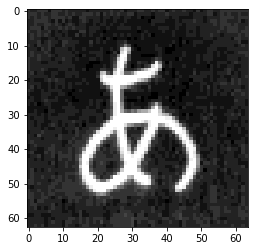

In [374]:
plt.imshow(df['image_matrix'][0], cmap='gray', interpolation='nearest')
plt.show()

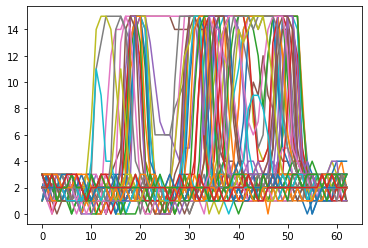

In [375]:
plt.plot(df['image_matrix'][0])
plt.show()

In [376]:
def remove_noise(bytes_matrix, threshold=5):
    cleaned_matrix = []
    for row in bytes_matrix:
        cleaned_row = [0 if px <= threshold else px for px in row]
        cleaned_matrix.append(np.array(cleaned_row))
    return np.array(cleaned_matrix)

clean_noise = lambda x: remove_noise(x['image_matrix'], threshold=6)

df['image_matrix'] = df.apply(clean_noise, axis=1)

df.head()

,phonetic,hiragana,image_matrix
0,A,あ,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,A,あ,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,A,あ,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,A,あ,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,A,あ,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


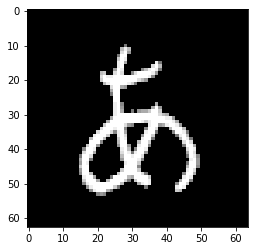

In [377]:
plt.imshow(df['image_matrix'][0], cmap='gray', interpolation='nearest')
plt.show()

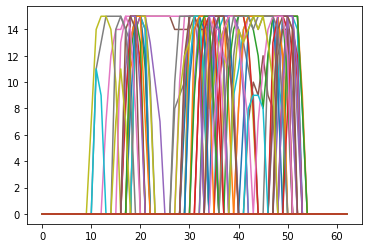

In [378]:
plt.plot(df['image_matrix'][0])
plt.show()

## 6 - Visualize the Data

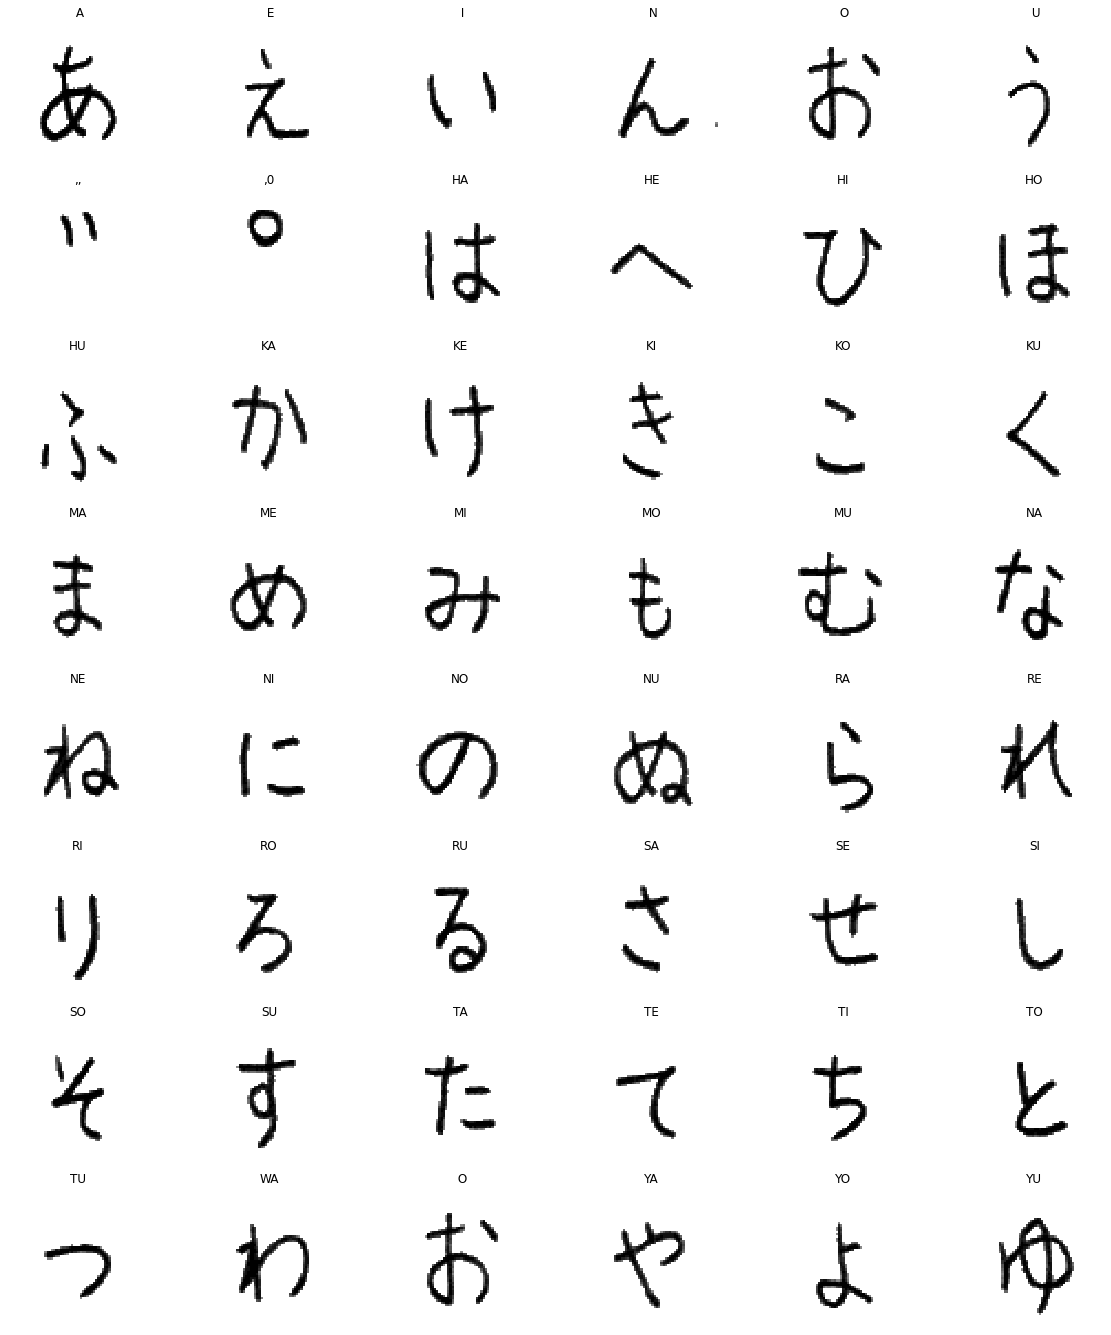

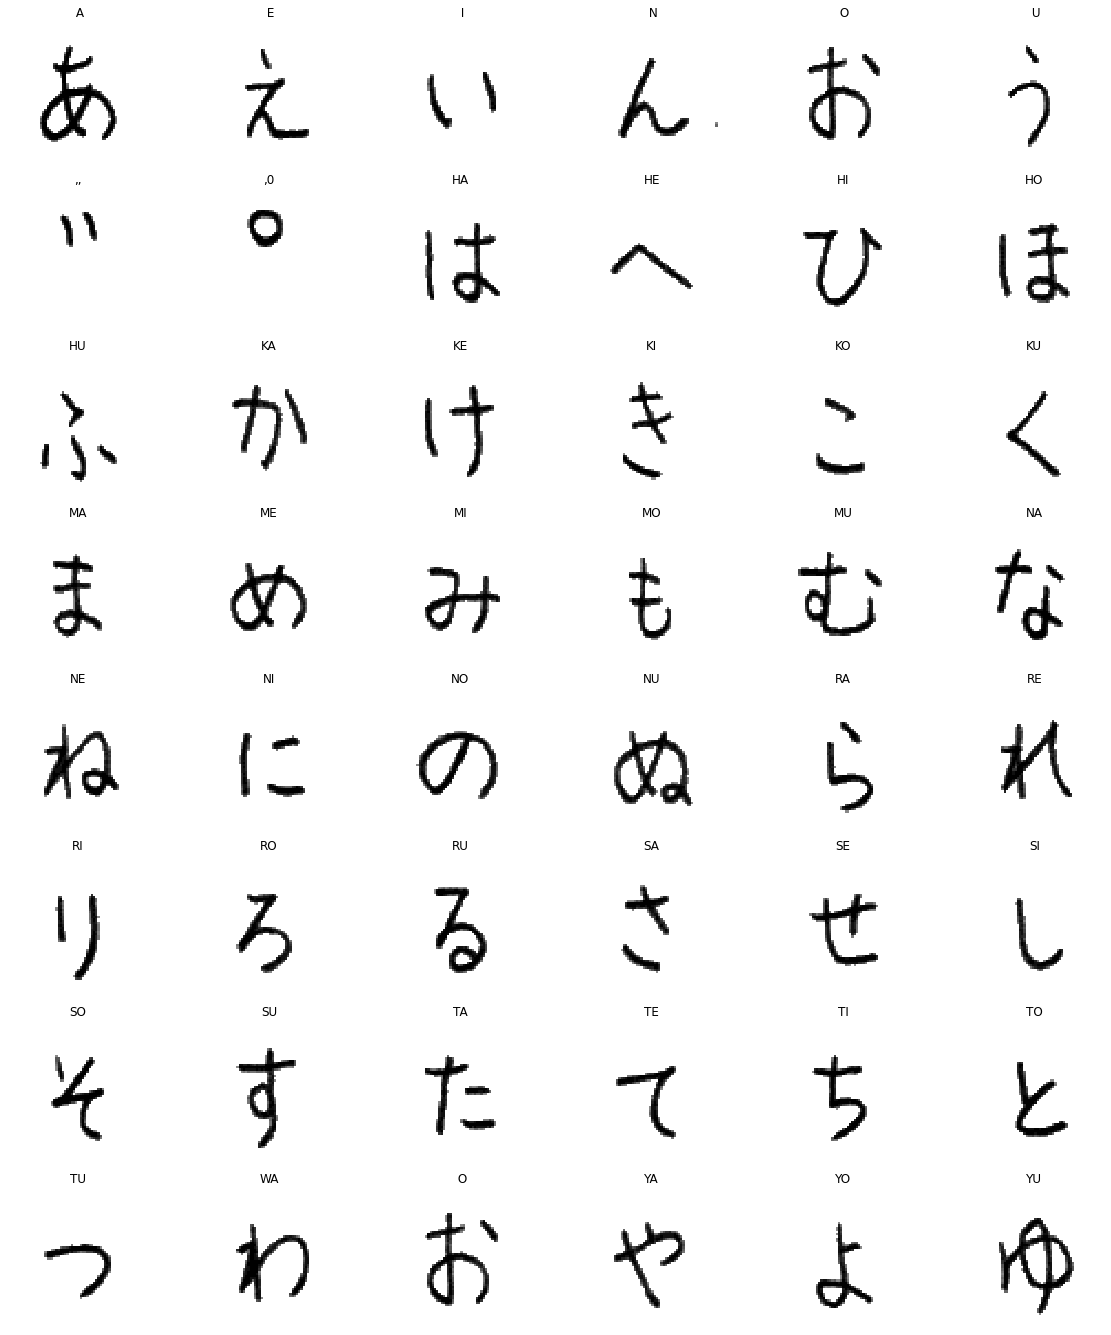

In [383]:
n_rows = 8
n_cols = 6
plt.rc('axes', unicode_minus=False)
_, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 24))

size = len(HIRAGANA) / 2
hiragana_list = list(HIRAGANA.values())

for index, value in enumerate(hiragana_list):
    x = int(index / n_cols)
    y = index % n_cols
    ax = axes[x][y]
    phonetic, _, image_matrix = df[df['hiragana'] == value].values[0]
    ax.imshow(image_matrix, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(phonetic)
    ax.axis('off')

plt.savefig('hiragana_data_gallery.jpg')
plt.show()

## 7 - Prepare Training Set

### 7.1 - Prepare Labels Dataset

In [397]:
labels = []
phonetics_list = df['phonetic']
unique_labels = phonetics_list.unique()
num_classes = phonetics_list.nunique()

# Transform labels to number for categorical classification
categorical_labels = keras.utils.to_categorical(np.arange(0, num_classes, 1))

for p in phonetics_list:
    label, = np.where(p == unique_labels)[0]
    labels.append(label)
    
labels = np.asarray(labels)
labels = categorical_labels[labels]
labels.shape

(33600, 48)

### 7.2 - Prepare Image Dataset

In [398]:
data = []

for image in df['image_matrix']:
    resized_image = skimage.transform.resize(image, TARGET_SIZE)
    data.append(resized_image)
    
data = np.array(data, dtype='float32')
data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)
data.shape

(33600, 48, 48, 1)

In [399]:
data[0].shape

(48, 48, 1)

### 7.3 - Split into Train & Test

In [400]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, shuffle=True)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (22512, 48, 48, 1)
y_train shape: (22512, 48)
X_test shape: (11088, 48, 48, 1)
y_test shape: (11088, 48)


### 7.4 - Rescale & Batch Data

In [401]:
data_generator = ImageDataGenerator(rescale=1.0/255)

train_set = data_generator.flow(X_train, y=y_train, batch_size=64)
test_set = data_generator.flow(X_test, y=y_test, batch_size=64)

## 8 - Create CNN Model

In [403]:
input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])

model = Sequential([
    Conv2D(32, (3,3), 
           activation='relu',
           input_shape=input_shape,
           padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(48, activation="softmax")
])

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, 
              loss="categorical_crossentropy",
              metrics=['accuracy']
             )

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1024)            

## 10 - Fit Model to Data

In [404]:
y_train.shape, X_train.shape

((22512, 48), (22512, 48, 48, 1))

In [405]:
history = model.fit(train_set, epochs=20, verbose=1)

Epoch 1/20
  1/352 [..............................] - ETA: 1:45 - loss: 3.8707 - accuracy: 0.0312

2022-04-29 14:56:17.524954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - 7s 19ms/step - loss: 1.1627 - accuracy: 0.6846
Epoch 2/20
352/352 [==============================] - 6s 18ms/step - loss: 0.2575 - accuracy: 0.9256
Epoch 3/20
352/352 [==============================] - 6s 18ms/step - loss: 0.1397 - accuracy: 0.9578
Epoch 4/20
352/352 [==============================] - 6s 18ms/step - loss: 0.0903 - accuracy: 0.9729
Epoch 5/20
352/352 [==============================] - 7s 19ms/step - loss: 0.0570 - accuracy: 0.9827
Epoch 6/20
352/352 [==============================] - 7s 19ms/step - loss: 0.0469 - accuracy: 0.9860
Epoch 7/20
352/352 [==============================] - 7s 18ms/step - loss: 0.0377 - accuracy: 0.9881
Epoch 8/20
352/352 [==============================] - 6s 18ms/step - loss: 0.0327 - accuracy: 0.9896
Epoch 9/20
352/352 [==============================] - 6s 18ms/step - loss: 0.0221 - accuracy: 0.9936
Epoch 10/20
352/352 [==============================] - 6s 18ms/step - loss: 0.0264 - accuracy: 0.9918


## 11 - Analyze model training

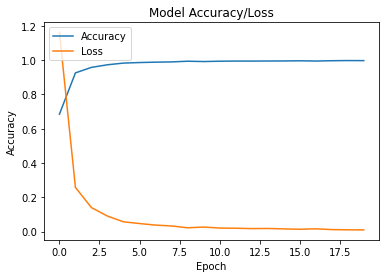

In [406]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

## 12 - Evaluate model

In [407]:
score = model.evaluate(X_test, y_test, verbose=0)

print(f'The prediction rate of the model is {format(score[1]*100,".2f")}% on {len(test_set)*len(test_set[0][0])} test images.')

2022-04-29 14:58:55.147652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The prediction rate of the model is 93.95% on 11136 test images.


## 13 - Test with new image

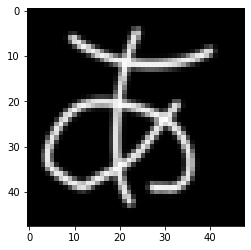

In [492]:
def load_image(path):
    temp_image = Image.open(path).convert('L')
    inverted_temp = PIL.ImageOps.invert(temp_image)
    array_temp = np.array(inverted_temp, dtype='float32')
    resized_temp = skimage.transform.resize(array_temp, TARGET_SIZE)
    reshaped_temp = resized_temp.reshape(resized_temp.shape[0], resized_temp.shape[1], 1)
    rescaled_temp = reshaped_temp/255
    return rescaled_temp

plt.imshow(load_image('handwritten/A.png'), cmap='gray');

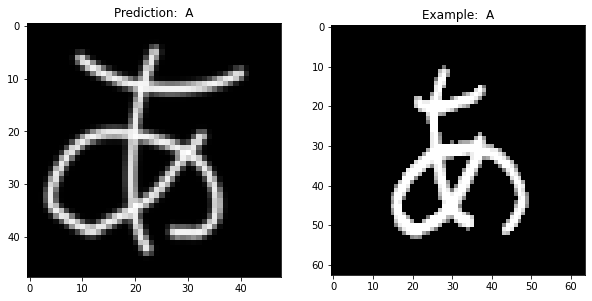

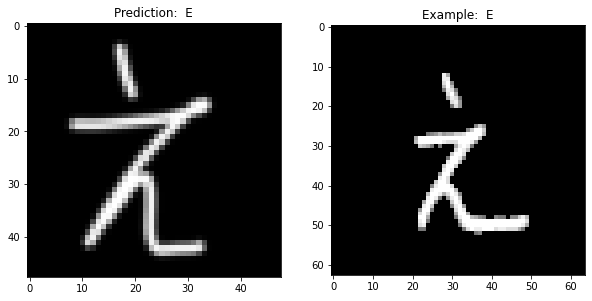

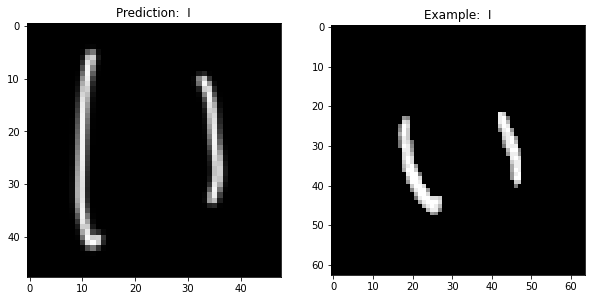

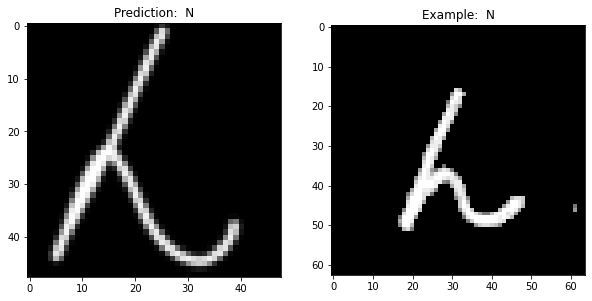

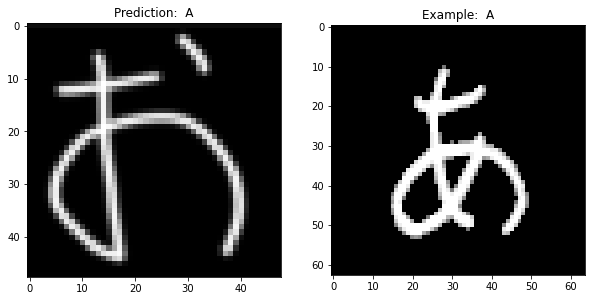

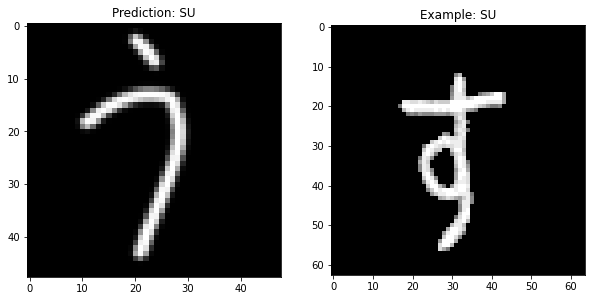

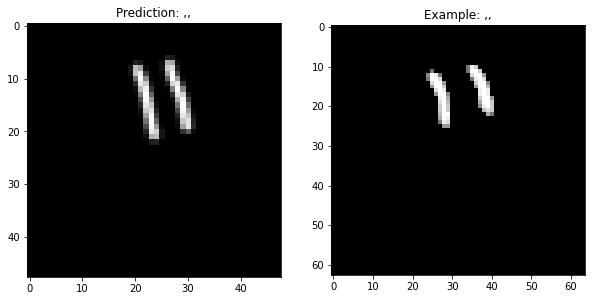

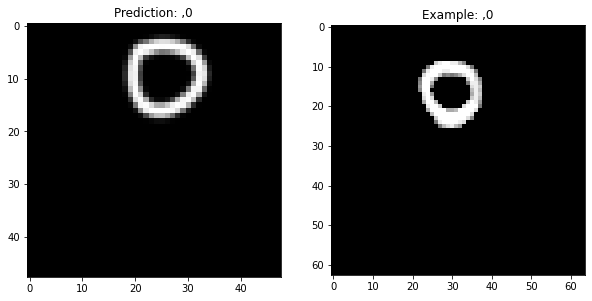

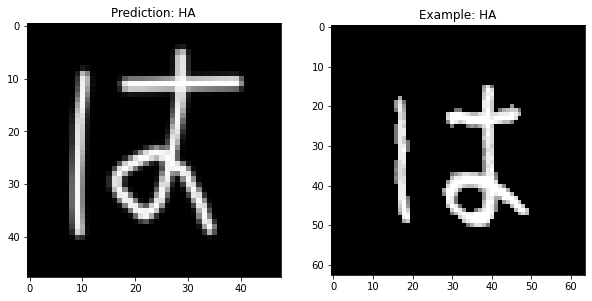

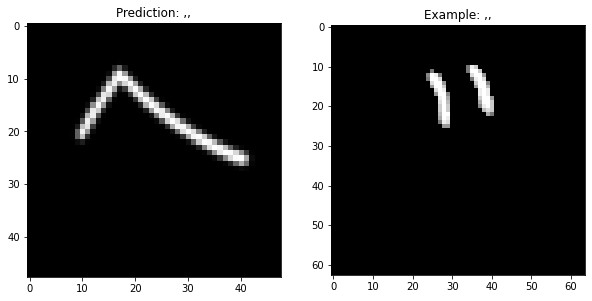

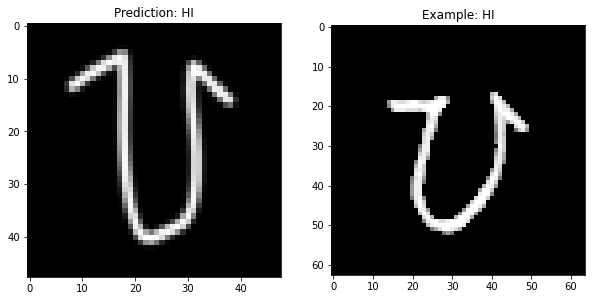

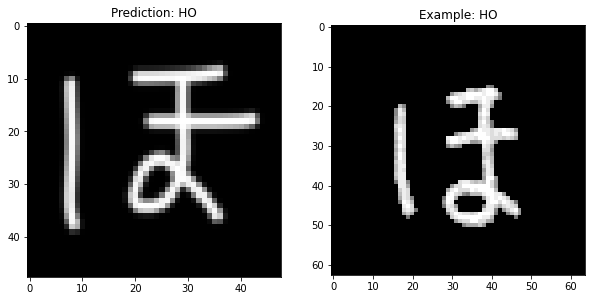

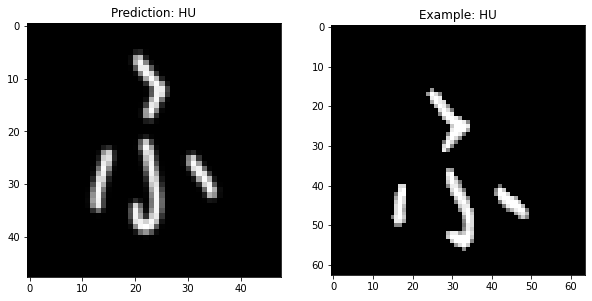

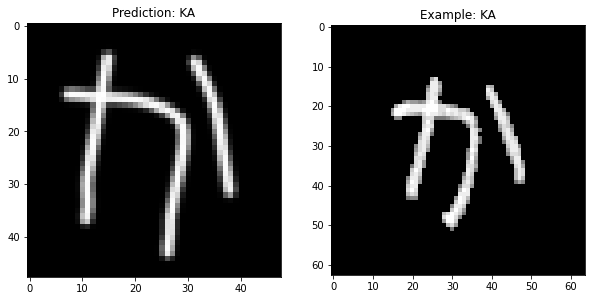

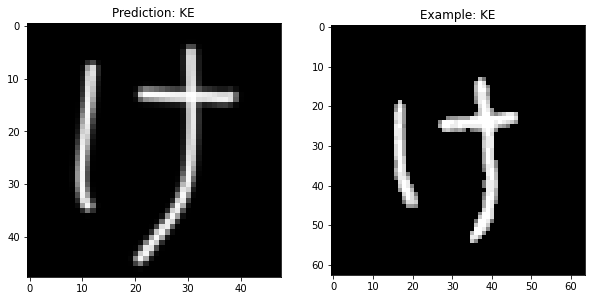

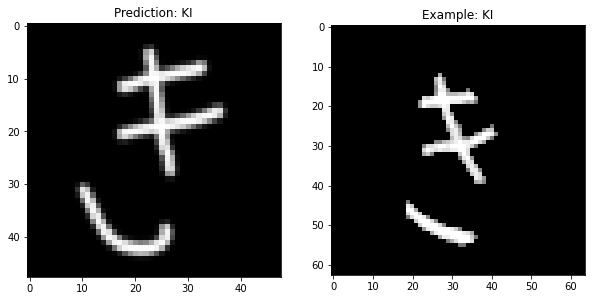

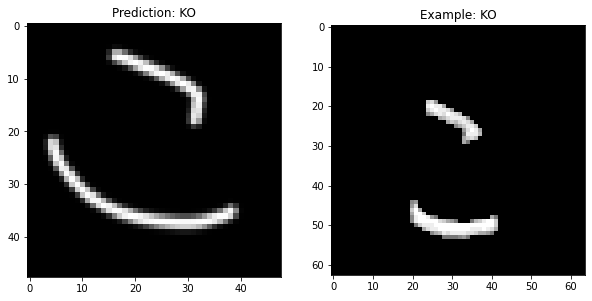

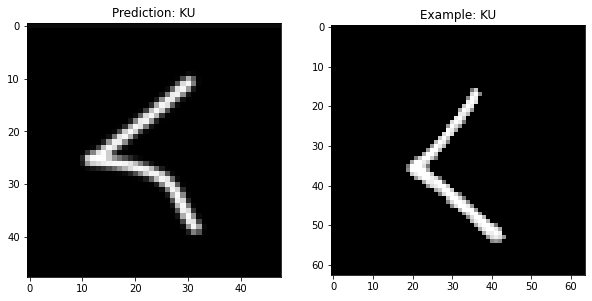

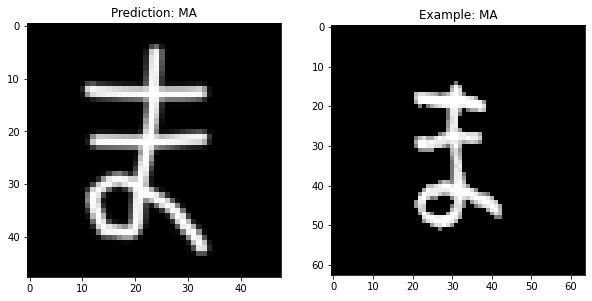

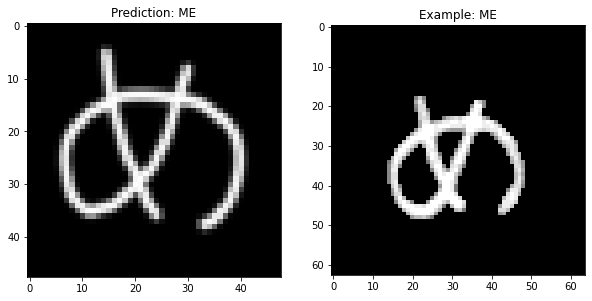

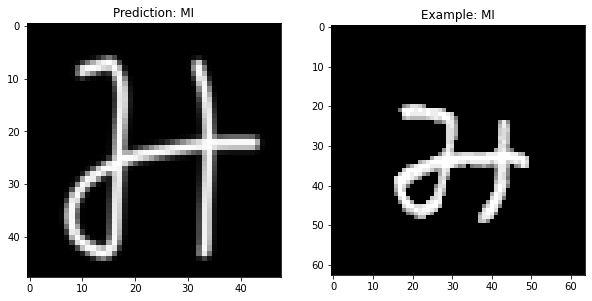

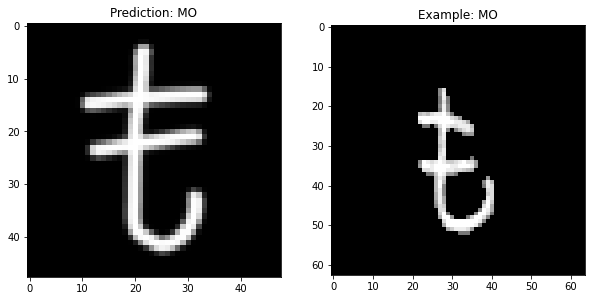

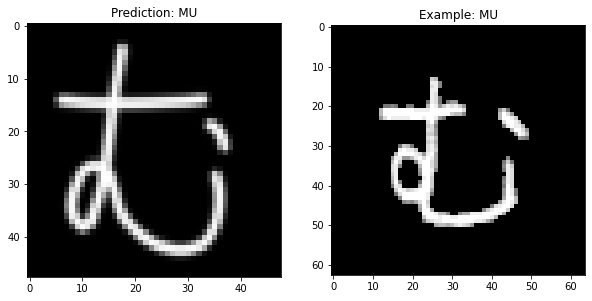

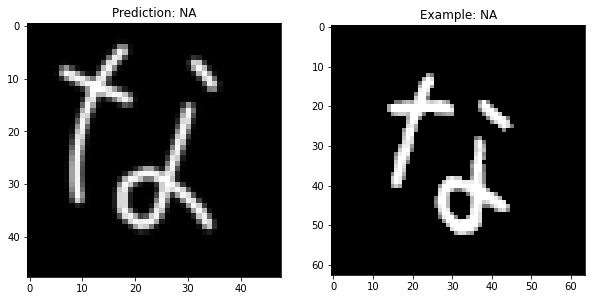

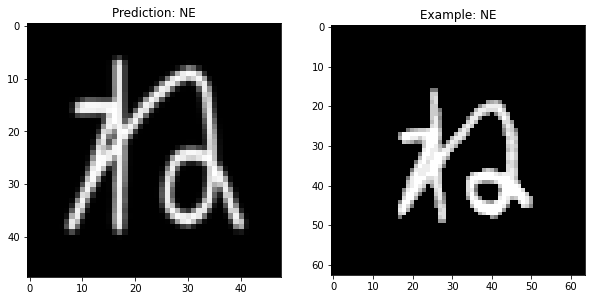

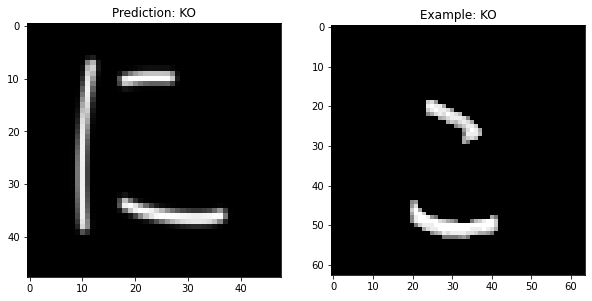

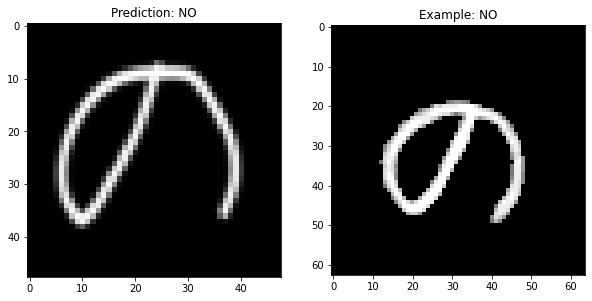

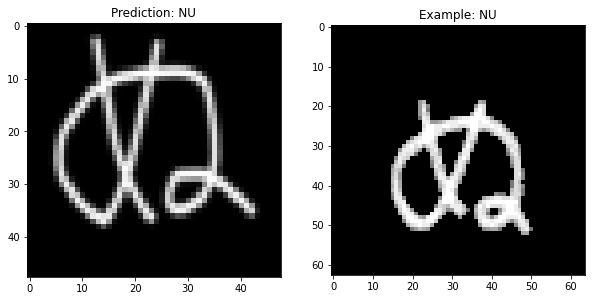

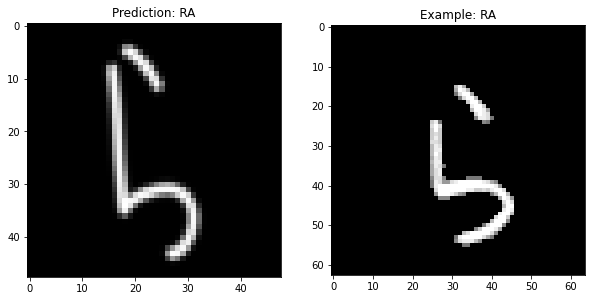

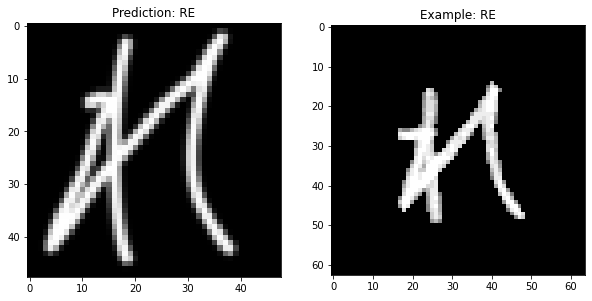

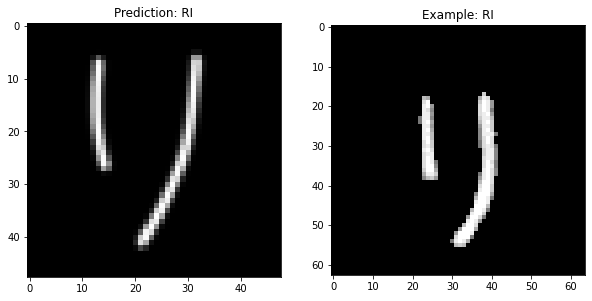

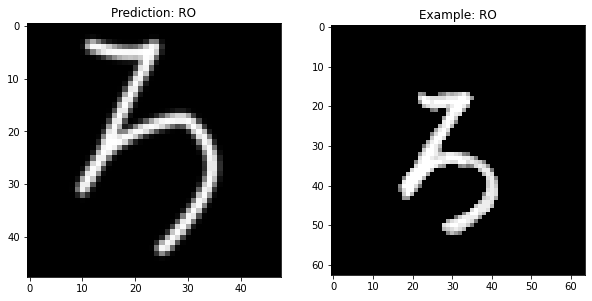

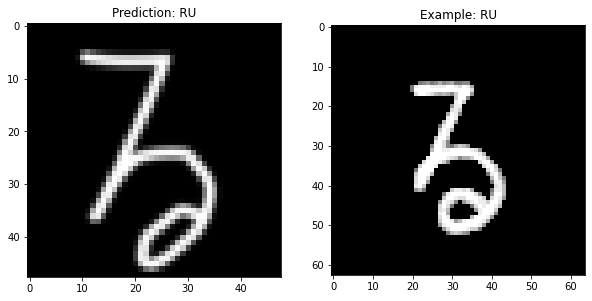

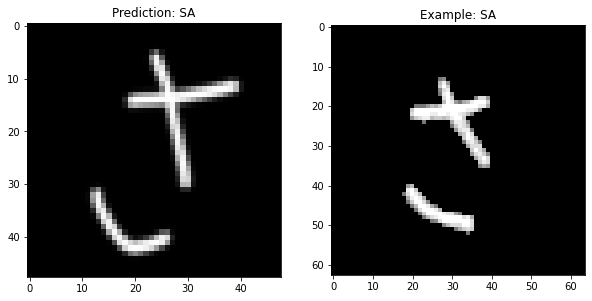

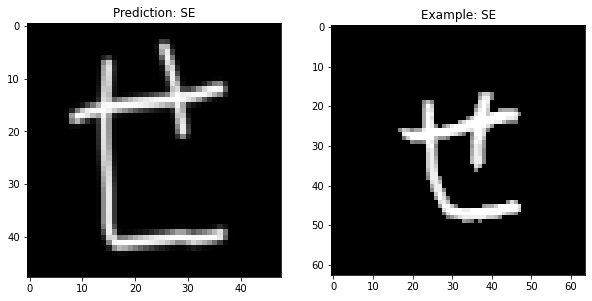

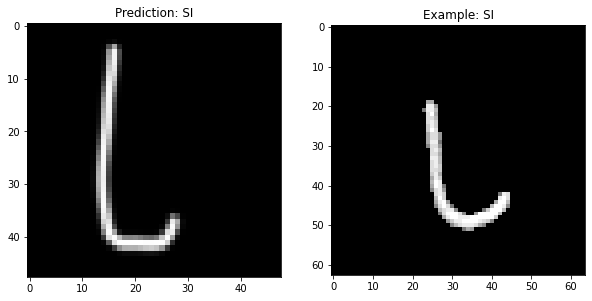

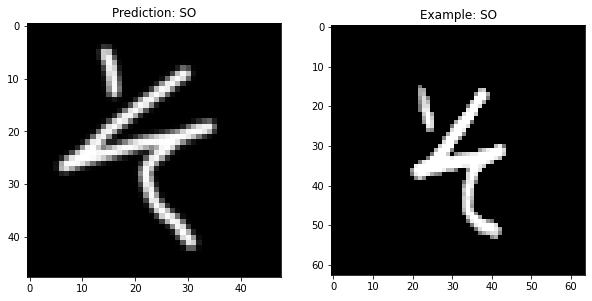

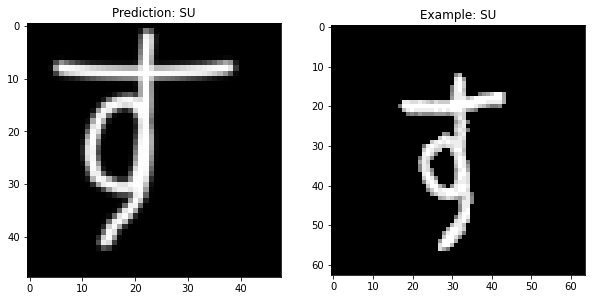

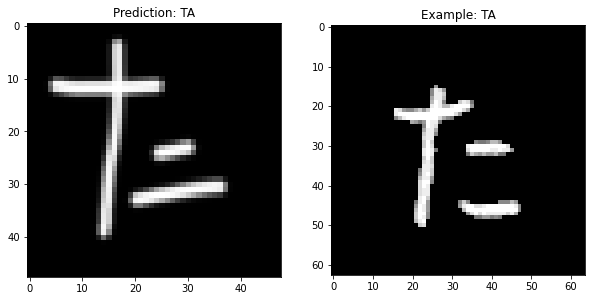

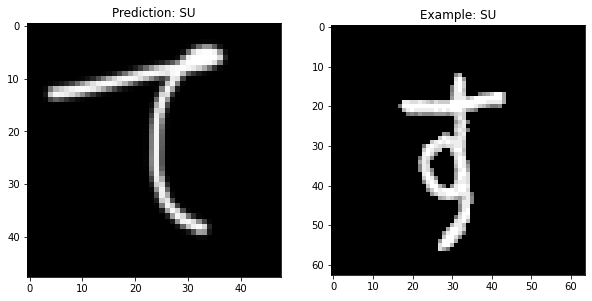

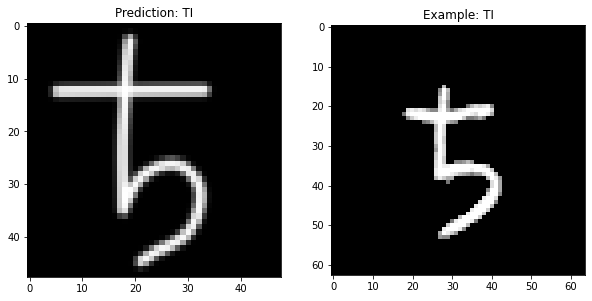

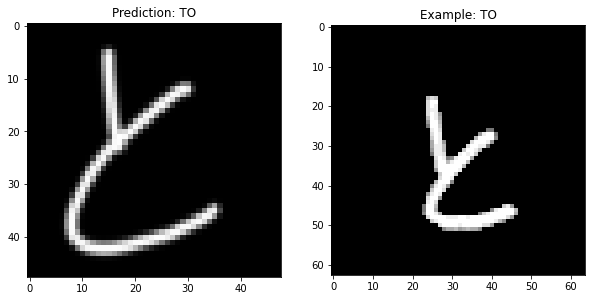

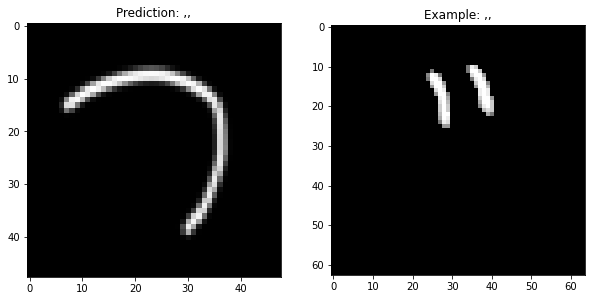

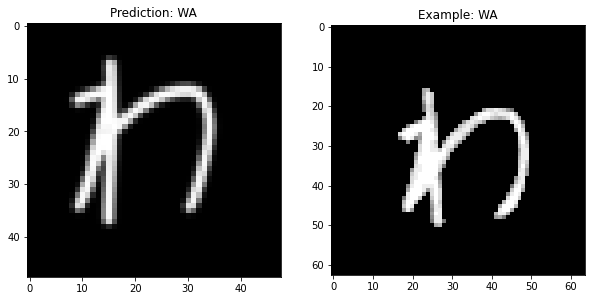

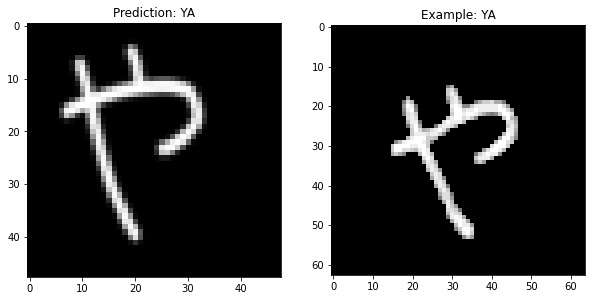

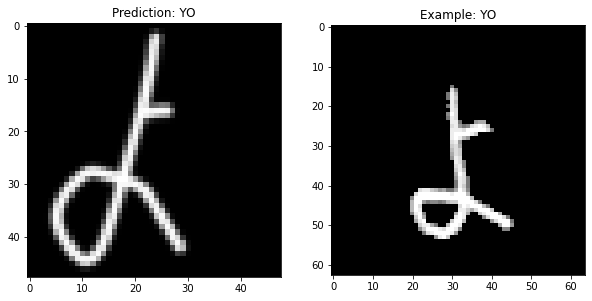

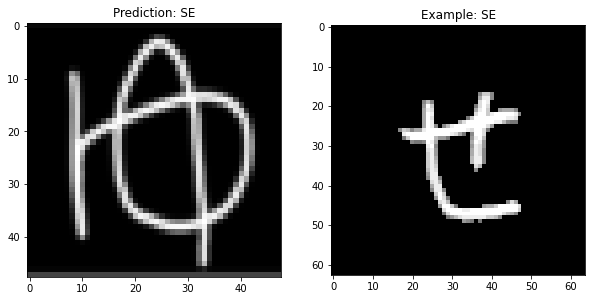

In [538]:
plt.rcParams['figure.max_open_warning'] = 50
handwritten_data = ['A', 'E', 'I', 'N', 'O', 'U', 'ponct_1', 'ponct_2', 'HA', 'HE', 'HI', 'HO', 'HU', 'KA', 'KE', 'KI', 'KO', 'KU', 'MA', 'ME', 'MI', 'MO', 'MU', 'NA', 'NE', 'NI','NO','NU', 'RA', 'RE', 'RI', 'RO', 'RU', 'SA', 'SE', 'SI', 'SO', 'SU', 'TA', 'TE', 'TI', 'TO', 'TU', 'WA', 'YA', 'YO', 'YU']

for index, char in enumerate(handwritten_data):
    prediction_image = load_image(f'handwritten/{char}.png')
    reshaped_prediction = prediction_image.reshape(1, prediction_image.shape[0], prediction_image.shape[1], 1)
    prediction = model.predict(reshaped_prediction)
    prediction_value = unique_labels[np.argmax(prediction)]
    # Plot
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax_pred = axes[0]
    ax_train = axes[1]
    ax_pred.imshow(prediction_image, cmap='gray');
    ax_pred.set_title(f'Prediction: {unique_labels[np.argmax(prediction)]}')
    ax_train.imshow(df[df['phonetic'] == prediction_value].values[0,2], cmap='gray');
    ax_train.set_title(f'Example: {unique_labels[np.argmax(prediction)]}');
    plt.savefig(f'predictions/{char}.png');